In [1]:
from mlrl.runners.dqn_runner import DQNRun
from mlrl.experiments.procgen_dqn import make_vectorised_procgen, create_rainbow_agent

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


pygame 2.1.3 (SDL 2.0.22, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using TensorFlow 2.12.0


In [2]:
folder = 'runs/categorical_dqn_agent/run-16823527592836354'

import json

with open(folder + '/config.json') as f:
    config = json.load(f)

config

{'action_repeats': 4,
 'agent_name': 'categorical_dqn_agent',
 'collect_steps_per_iteration': 1,
 'discount': 0.999,
 'env': 'bigfish',
 'epsilon': 0.1,
 'epsilon_decay_steps': 250000,
 'epsilon_schedule': False,
 'eval_steps': 1000,
 'experience_batch_size': 64,
 'final_epsilon': 0.1,
 'frame_stack': 0,
 'grayscale': False,
 'initial_collect_steps': 500,
 'initial_epsilon': 1.0,
 'learning_rate': 0.00025,
 'max_epochs': 500,
 'metrics': [],
 'model_config': 'N/A',
 'n_collect_envs': 64,
 'n_eval_envs': 64,
 'n_video_envs': 12,
 'name': 'run',
 'optimiser_config': {'amsgrad': False,
  'beta_1': 0.8999999761581421,
  'beta_2': 0.9990000128746033,
  'decay': 0.0,
  'epsilon': 1e-07,
  'learning_rate': 0.0002500000118743628,
  'name': 'Adam'},
 'procgen_env_name': 'bigfish',
 'replay_buffer_capacity': 1024,
 'run_dir': './runs/categorical_dqn_agent/run-16823527592836354',
 'target_network_update_period': 10000,
 'train_steps_per_epoch': 20000,
 'video_seconds': 60}

In [4]:
env = make_vectorised_procgen(config, n_envs=8)
q_net, agent = create_rainbow_agent(env, config)

In [ ]:
q_vals, _ = q_net(env.current_time_step().observation)
q_vals.shape

TensorShape([8, 15, 51])

In [3]:
import re
from typing import Tuple


def parse_model_weights_string(path: str) -> Tuple[int, float]:
    pattern = r"sequential_best_(\d+)_(\d+\.\d+).index"

    match = re.match(pattern, path)

    if match:
        epoch = int(match.group(1))
        value = float(match.group(2))
        return epoch, value

    return None

In [4]:
from pathlib import Path

model_paths = [
    (str(path).replace('.index', ''), *values)
    for path in Path(f'{folder}/model_weights').glob('*')
    if path.is_file() and str(path).endswith('.index') 
        and (values := parse_model_weights_string(str(path.name))) is not None
]

In [5]:
model_paths = sorted(model_paths, key=lambda x: x[1])

In [6]:
path, epoch, ret_val = max(model_paths, key=lambda x: x[2])
path, epoch, ret_val

('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_65_40.599998',
 65,
 40.599998)

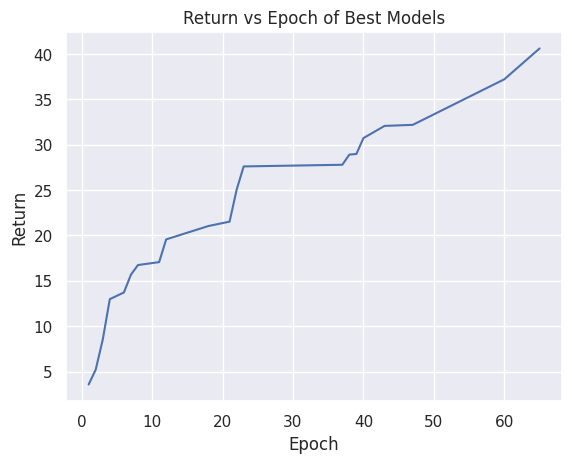

In [7]:
epochs = [epoch for _, epoch, _ in model_paths]
ret_vals = [ret_val for _, _, ret_val in model_paths]

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

plt.plot(epochs, ret_vals)
plt.xlabel('Epoch')
plt.ylabel('Return')
plt.title('Return vs Epoch of Best Models')
plt.show()

In [8]:
from typing import List, Tuple


def get_model_at_return_percentile(model_paths: List[Tuple[str, int, float]], percentile: float) -> Tuple[str, int, float]:
    sorted_paths = sorted(model_paths, key=lambda x: x[2])
    index = int(len(sorted_paths) * percentile)
    return model_paths[index]

In [9]:
get_model_at_return_percentile(model_paths, 0.75)

('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_39_28.971098',
 39,
 28.971098)

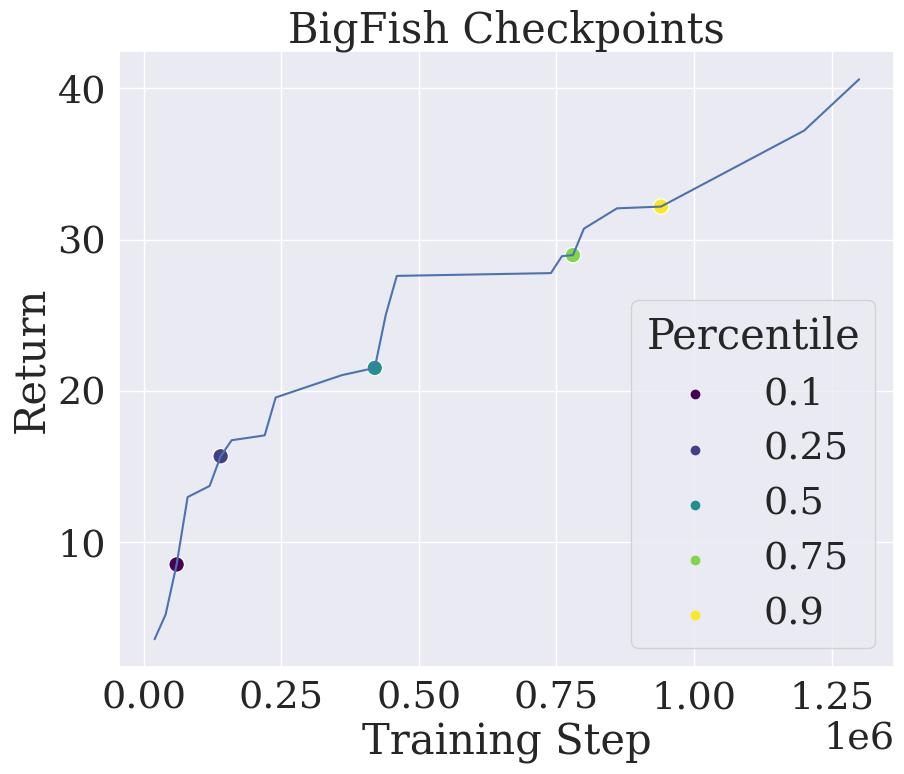

In [21]:
step_per_epoch = config['train_steps_per_epoch']
epochs = [epoch*step_per_epoch for _, epoch, _ in model_paths]
ret_vals = [ret_val for _, _, ret_val in model_paths]

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=2.5)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

plt.figure(figsize=(10, 8))
plt.plot(epochs, ret_vals)

import pandas as pd

percentile_df = pd.DataFrame([
    {
        'Percentile': percentile,
        **dict(zip(['Epoch', 'Return'], get_model_at_return_percentile(model_paths, percentile)[1:]))
    }
    for percentile in [0.1, 0.25, 0.5, 0.75, 0.9]
])
percentile_df['Training Step'] = percentile_df['Epoch'] * step_per_epoch

sns.scatterplot(data=percentile_df, x='Training Step', y='Return',
                hue='Percentile', s=125, legend='full', palette='viridis')

# for percentile in [0.1, 0.25, 0.5, 0.75, 0.9]:
#     _, epoch, ret = get_model_at_return_percentile(model_paths, percentile)
#     plt.scatter([epoch*step_per_epoch], [ret], label=f'Percentile {percentile:.2f}')

plt.xlabel('Training Step')
plt.ylabel('Return')
plt.title('BigFish Checkpoints')
plt.legend(loc='lower right', title='Percentile')
plt.show()

In [12]:
path, *info = get_model_at_return_percentile(model_paths, 0.5)
path, *info

('runs/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_21_21.514286',
 21,
 21.514286)

In [13]:
chkpt_status = q_net.load_weights(path)

In [14]:
q_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CategoricalQNetwork (Catego  ((8, 15, 51),            638909    
 ricalQNetwork)               ())                                
                                                                 
Total params: 638,909
Trainable params: 638,909
Non-trainable params: 0
_________________________________________________________________


In [15]:
from mlrl.runners.eval_runner import EvalRunner

In [19]:
eval_runner = EvalRunner(10000 * env.batch_size, env, agent.policy)

In [20]:
eval_runner.run()

80006/80000 [==============================] - 29s 363us/step - AverageReturn: 22.9430
Evaluation stats:
EvalTime: 29.082


{'EvalNumberOfEpisodes': 322,
 'EvalEnvironmentSteps': 80006,
 'EvalAverageReturn': 26.189442,
 'EvalAverageEpisodeLength': 244.62733,
 'EvalTime': 29.082419872283936}

In [21]:
from mlrl.experiments.procgen_dqn import create_video_renderer
from mlrl.utils.render_utils import embed_mp4

In [22]:
renderer = create_video_renderer(config)

In [23]:
embed_mp4(renderer(agent.policy, 'video.mp4'))

In [20]:
from mlrl.procgen.procgen_state import ProcgenState, ProcgenProcessing

In [21]:
ProcgenProcessing.set_pretrained_agent(agent)

In [22]:
allowed_actions = [
    combo for combo in ProcgenState.COMBO_STRINGS
    if any(allowed_key in combo for allowed_key in ['LEFT', 'RIGHT', 'UP', 'DOWN'])
]
print(', '.join(allowed_actions))
ProcgenState.set_actions(allowed_actions)

LEFT+DOWN, LEFT, LEFT+UP, DOWN, UP, RIGHT+DOWN, RIGHT, RIGHT+UP


In [27]:
state = ProcgenState.extract_state(env)
state

ProcgenState(3803566544258403892)

In [ ]:
state.COMBO_STRINGS

['LEFT+DOWN',
 'LEFT',
 'LEFT+UP',
 'DOWN',
 'UP',
 'RIGHT+DOWN',
 'RIGHT',
 'RIGHT+UP']

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [29]:
# from IPython.display import clear_output
# import numpy as np


# try:
#     for _ in range(1000):
#         ts = env.current_time_step()
#         action = agent.policy.action(ts).action
#         env.step(action)

#         fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#         state = ProcgenState.extract_state(env)
#         obs = state.observation
#         q_values = state.q_values

#         sns.barplot(x=np.arange(len(q_values)), y=q_values, ax=axs[0])
#         axs[0].set_xticklabels(ProcgenState.COMBO_STRINGS, rotation=90)
#         axs[0].set_title('Q Values')

#         axs[1].imshow(obs[0])
#         axs[1].set_title(f'Observation. Action: {ProcgenState.COMBO_STRINGS[action.numpy()[0]]}')
#         axs[1].axis('off')

#         plt.show()

#         clear_output(wait=True)
# except KeyboardInterrupt:
#     pass

In [23]:
from mlrl.experiments.procgen_meta import create_batched_procgen_meta_envs

In [24]:
args = {
    'pretrained_runs_folder': 'runs',
    'pretrained_run': 'run-16823527592836354',
    'pretrained_percentile': 0.75,
    'expand_all_actions': True,
    'finish_on_terminate': True,
    'max_tree_size': 32,
}


batched_meta_envs = create_batched_procgen_meta_envs(4, config, **args)

In [17]:
import numpy as np

In [ ]:
img = batched_meta_envs.render()
img = np.concatenate(img, axis=0)

In [ ]:
# plt.figure(figsize=(10 * 4, 20))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [ ]:
# ts = env.step(0)

In [ ]:
import gym
import procgen

gym_env = gym.make('procgen:procgen-bigfish-v0',
                   distribution_mode='easy',
                   use_backgrounds=False,
                   restrict_themes=True)

def render(*args, **kwargs):
    return gym_env.env.observe()[1][0]

gym_env.render = render

original_step = gym_env.step

def repeated_step(*args, **kwargs):
    reward = 0
    for _ in range(config.get('action_repeats')):
        observation, r, *info = original_step(*args, **kwargs)
        reward += r
    return observation, reward, *info

gym_env.step = repeated_step

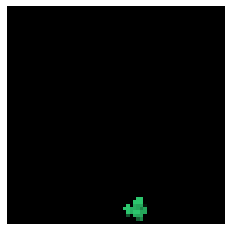

In [ ]:
obs = gym_env.reset() / 255.0
plt.imshow(obs)
plt.axis('off')
plt.show()

In [ ]:
obs, *_ = gym_env.step(0)
obs.shape

(64, 64, 3)

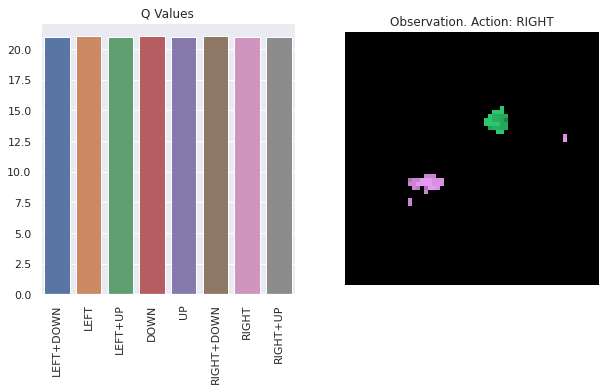

In [332]:
from IPython.display import clear_output
import numpy as np


try:
    obs = gym_env.reset() / 255.
    for _ in range(1000):
        _, q_vals = ProcgenProcessing.call(np.expand_dims(obs, 0))
        action = q_vals[ProcgenState.ACTIONS].argmax()
        obs, *_ = gym_env.step(ProcgenState.ACTIONS[action])
        obs = obs / 255.0

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # state = ProcgenState.extract_state(env)
        # obs = state.observation
        q_values = state.q_values[ProcgenState.ACTIONS]

        sns.barplot(x=np.arange(len(q_values)), y=q_values, ax=axs[0])
        axs[0].set_xticklabels(ProcgenState.COMBO_STRINGS, rotation=90)
        axs[0].set_title('Q Values')

        axs[1].imshow(np.clip(obs, 0, 1))
        axs[1].set_title(f'Observation. Action: {ProcgenState.COMBO_STRINGS[action]}')
        axs[1].axis('off')

        plt.show()

        clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [18]:
from mlrl.experiments.experiment_utils import create_meta_env
from mlrl.procgen.meta_renderer import render_tree_policy


def create_procgen_meta_env():

    q_hat = lambda s, a: s.q_values[a]

    meta_config = {
        'expand_all_actions': True,
        'max_tree_size': 256
    }

    return create_meta_env(
        gym_env, ProcgenState.extract_state(gym_env),
        q_hat, meta_config,
        tree_policy_renderer=render_tree_policy,
        # min_computation_steps=min_computation_steps
    )

In [19]:
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy

In [ ]:
# tf_meta_env = BatchedPyEnvironment([GymWrapper(create_procgen_meta_env())])
# tf_meta_env.reset();

In [21]:
a_star_policy = AStarPolicy(batched_meta_envs)

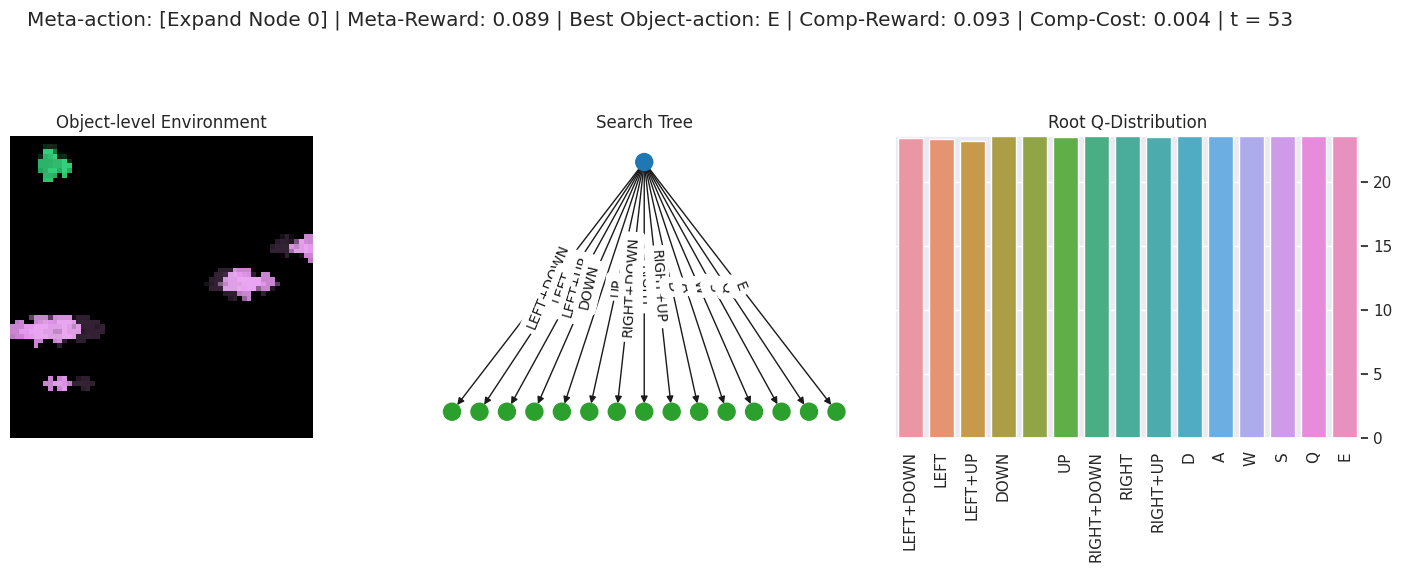

In [22]:
from IPython.display import clear_output

try:
    time_step = batched_meta_envs.reset()
    while True:
        batched_meta_envs.envs[0].render(plt_show=True)
        clear_output(wait=True)
        time_step = batched_meta_envs.current_time_step()
        policy_step = a_star_policy.action(time_step)
        batched_meta_envs.step(policy_step.action)

except KeyboardInterrupt:
    pass

In [1]:
from mlrl.experiments.procgen_meta import create_runner

args = {
    'pretrained_runs_folder': 'runs',
    'pretrained_run': 'run-16823527592836354',
    'pretrained_percentile': 0.75,
    'expand_all_actions': True,
    'finish_on_terminate': True,
    'max_tree_size': 32,
    'rewrite_rewards': True,
    'max_cost_of_computation': 0.,
}

runner = create_runner(args)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


pygame 2.1.3 (SDL 2.0.22, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using TensorFlow 2.12.0
Object-level config:
	 - action_repeats: 4
	 - agent_name: categorical_dqn_agent
	 - collect_steps_per_iteration: 1
	 - discount: 0.999
	 - env: bigfish
	 - epsilon: 0.1
	 - epsilon_decay_steps: 250000
	 - epsilon_schedule: False
	 - eval_steps: 1000
	 - experience_batch_size: 64
	 - final_epsilon: 0.1
	 - frame_stack: 0
	 - grayscale: False
	 - initial_collect_steps: 500
	 - initial_epsilon: 1.0
	 - learning_rate: 0.00025
	 - max_epochs: 500
	 - metrics: []
	 - model_config: N/A
	 - n_collect_envs: 64
	 - n_eval_envs: 64
	 - n_video_envs: 12
	 - name: run
	 - optimiser_config: {'amsgrad': False, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'learning_rate': 0.0002500000118743628, 'name': 'Adam'}
	 - procgen_env_name: bigfish
	 - replay_buffer_capacity: 1024
	 - run_dir: ./runs/categorical_dqn_agent/run-16

In [2]:
from mlrl.utils.render_utils import embed_mp4

runner.evaluator.rewrite_rewards = True
embed_mp4(runner.evaluator.create_policy_eval_video(60))

In [3]:
from mlrl.meta.meta_env import MetaEnv
meta_env0: MetaEnv = runner.collect_env.envs[0]

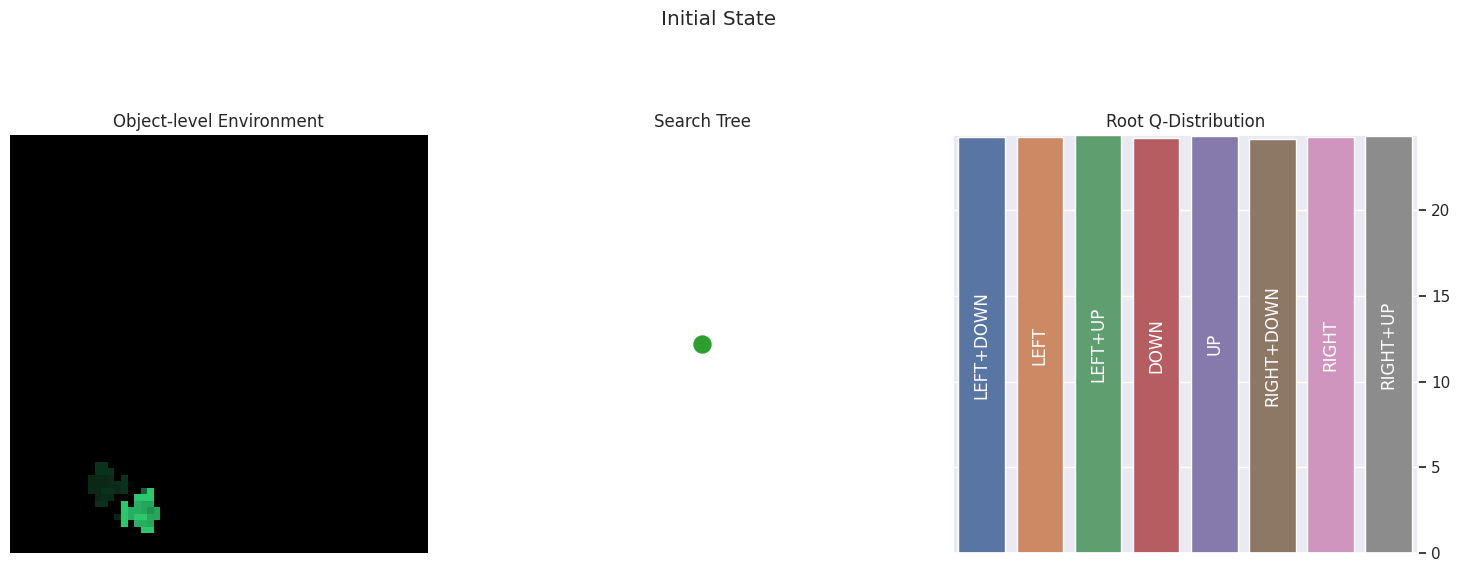

Estimating value of new policy:
 {ProcgenState(4497429490976276650)}
|---[LEFT+DOWN, 0.000, 24.260]--> (ProcgenState(1595925770293818612))
|---[LEFT, 0.000, 24.266]--> (ProcgenState(6786211660392858645))
|---[LEFT+UP, 0.000, 24.375]--> (ProcgenState(-3937302075099144311))
|---[DOWN, 0.000, 24.207]--> (ProcgenState(6054935194080467234))
|---[UP, 0.000, 24.364]--> (ProcgenState(-5477933334736900163))
|---[RIGHT+DOWN, 0.000, 24.176]--> (ProcgenState(1886500693584271757))
|---[RIGHT, 0.000, 24.279]--> (ProcgenState(9221254593300392982))
|---[RIGHT+UP, 0.000, 24.328]--> (ProcgenState(1121810385985857365))
P(LEFT+DOWN | ProcgenState(4497429490976276650)) = 0.0, P(LEFT | ProcgenState(4497429490976276650)) = 0.0, P(LEFT+UP | ProcgenState(4497429490976276650)) = 1.0, P(DOWN | ProcgenState(4497429490976276650)) = 0.0, P(UP | ProcgenState(4497429490976276650)) = 0.0, P(RIGHT+DOWN | ProcgenState(4497429490976276650)) = 0.0, P(RIGHT | ProcgenState(4497429490976276650)) = 0.0, P(RIGHT+UP | ProcgenSt

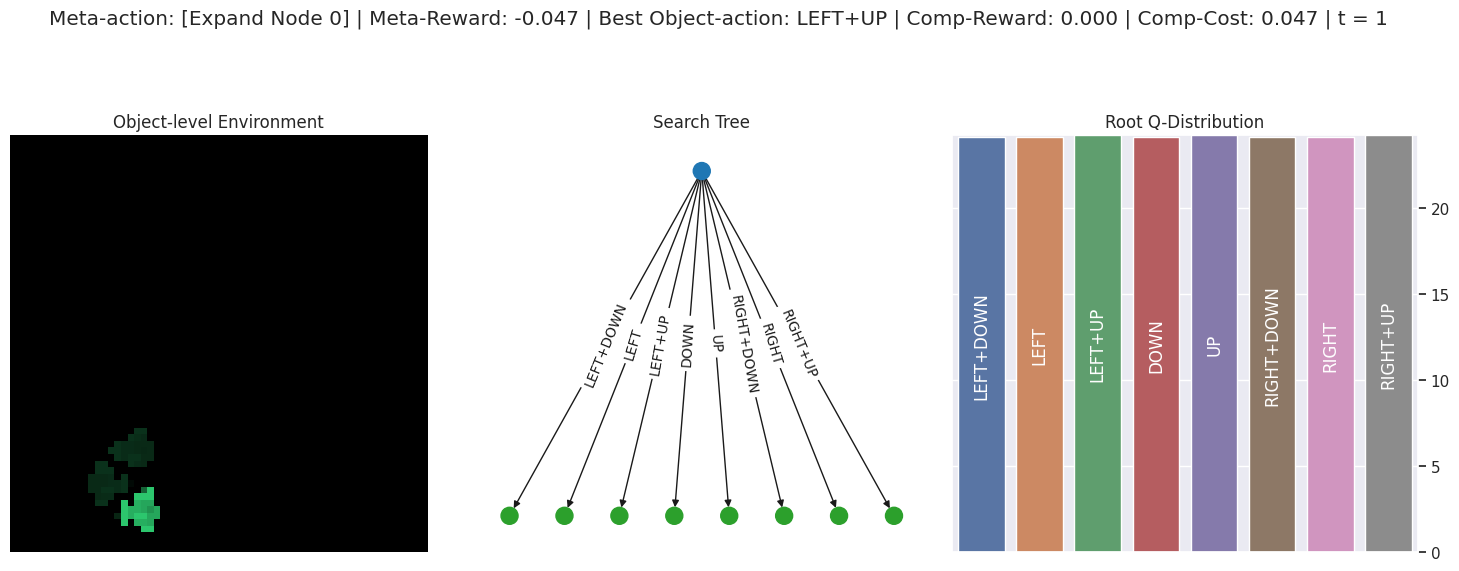

In [4]:
meta_env0.verbose = True
meta_env0.render(plt_show=True)

time_step = runner.collect_env.current_time_step()
policy_step = runner.collect_policy.action(time_step)
time_step = runner.collect_env.step(policy_step.action)

meta_env0.render(plt_show=True);

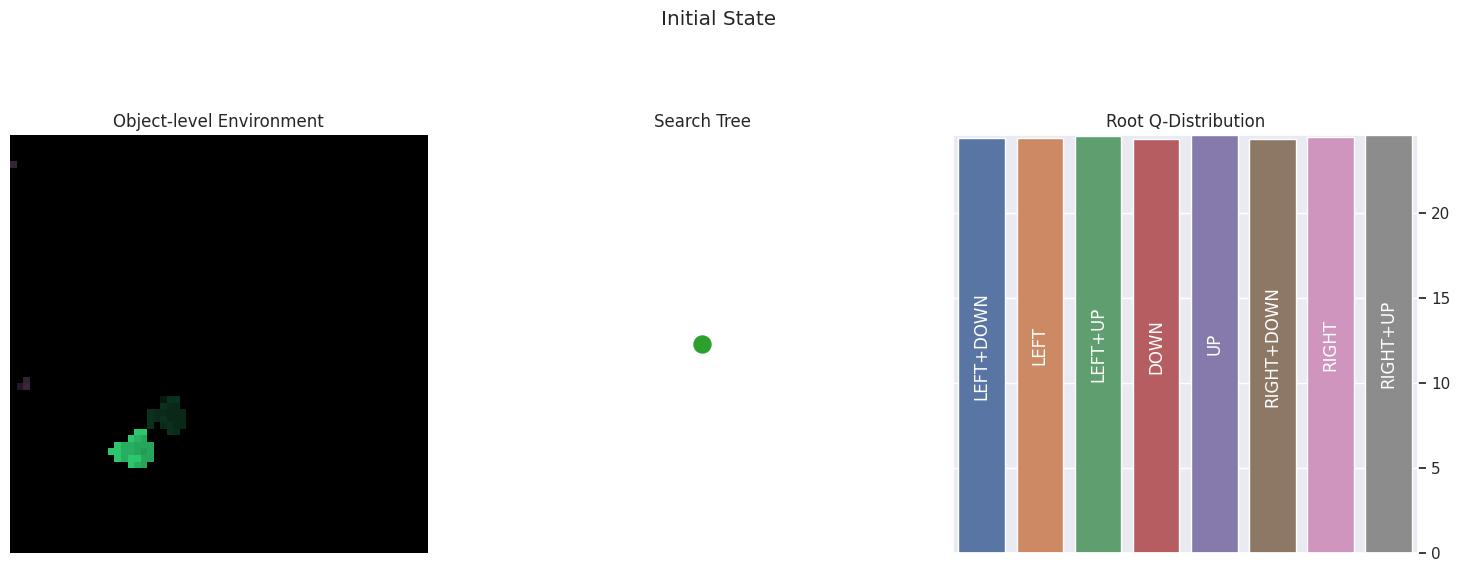

Estimating value of new policy:
 {ProcgenState(-5924664988174711309)}
|---[LEFT+DOWN, 0.000, 24.422]--> (ProcgenState(-4242163094017393146))
|---[LEFT, 0.000, 24.454]--> (ProcgenState(1356534834892271506))
|---[LEFT+UP, 0.000, 24.551]--> (ProcgenState(-5412069882440124751))
|---[DOWN, 0.000, 24.373]--> (ProcgenState(-3089451721770349657))
|---[UP, 0.000, 24.597]--> (ProcgenState(2576777692974832595))
|---[RIGHT+DOWN, 0.000, 24.377]--> (ProcgenState(-3164555754333413939))
|---[RIGHT, 0.000, 24.500]--> (ProcgenState(8378615737415555554))
|---[RIGHT+UP, 0.000, 24.602]--> (ProcgenState(8830946523746955146))
P(LEFT+DOWN | ProcgenState(-5924664988174711309)) = 0.0, P(LEFT | ProcgenState(-5924664988174711309)) = 0.0, P(LEFT+UP | ProcgenState(-5924664988174711309)) = 0.0, P(DOWN | ProcgenState(-5924664988174711309)) = 0.0, P(UP | ProcgenState(-5924664988174711309)) = 0.0, P(RIGHT+DOWN | ProcgenState(-5924664988174711309)) = 0.0, P(RIGHT | ProcgenState(-5924664988174711309)) = 0.0, P(RIGHT+UP |

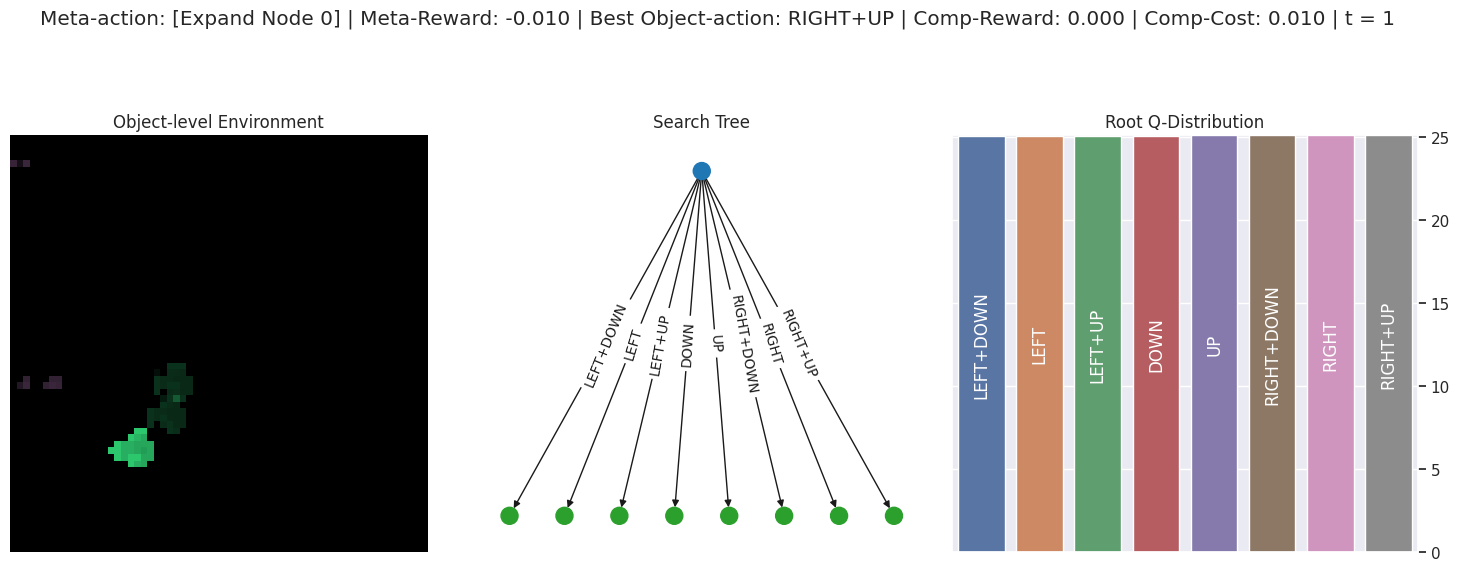

Estimating value of new policy:
 {ProcgenState(-5924664988174711309)}
|---[LEFT+DOWN, 0.000, 25.030]--> (ProcgenState(-4242163094017393146))
|---[LEFT, 0.000, 25.066]--> (ProcgenState(1356534834892271506))
|---[LEFT+UP, 0.000, 25.016]--> {ProcgenState(-5412069882440124751)}
	|---[LEFT+DOWN, 0.000, 25.141]--> (ProcgenState(-5839237696344012512))
	|---[LEFT, 1.000, 25.132]--> (ProcgenState(7349699056094574221))
	|---[LEFT+UP, 1.000, 25.228]--> (ProcgenState(7451205567167726283))
	|---[DOWN, 0.000, 25.162]--> (ProcgenState(-7617818162261354527))
	|---[UP, 0.000, 25.269]--> (ProcgenState(249155052395733830))
	|---[RIGHT+DOWN, 0.000, 25.167]--> (ProcgenState(5042011461108548719))
	|---[RIGHT, 0.000, 25.235]--> (ProcgenState(8397484062284802029))
	|---[RIGHT+UP, 0.000, 25.244]--> (ProcgenState(-7400364387082612648))
|---[DOWN, 0.000, 25.042]--> (ProcgenState(-3089451721770349657))
|---[UP, 0.000, 25.104]--> (ProcgenState(2576777692974832595))
|---[RIGHT+DOWN, 0.000, 25.097]--> (ProcgenState(

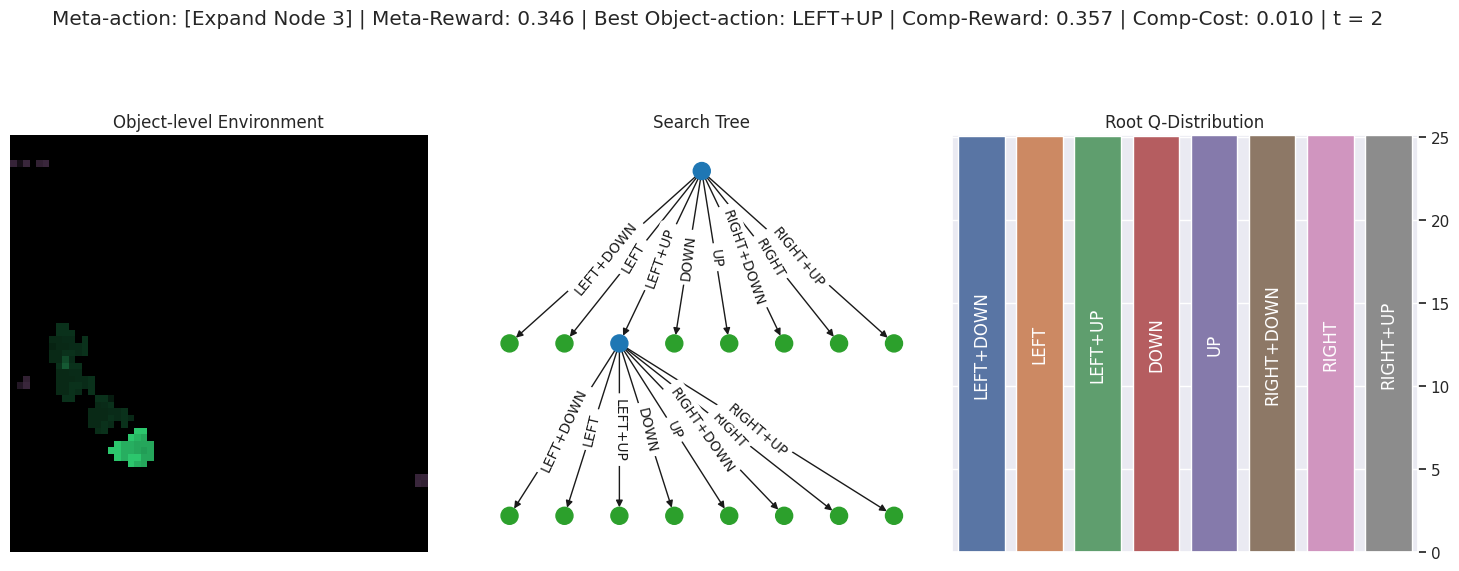

Estimating value of new policy:
 {ProcgenState(-5924664988174711309)}
|---[LEFT+DOWN, 0.000, 25.030]--> (ProcgenState(-4242163094017393146))
|---[LEFT, 0.000, 25.066]--> (ProcgenState(1356534834892271506))
|---[LEFT+UP, 0.000, 25.016]--> {ProcgenState(-5412069882440124751)}
	|---[LEFT+DOWN, 0.000, 25.141]--> (ProcgenState(-5839237696344012512))
	|---[LEFT, 1.000, 25.132]--> (ProcgenState(7349699056094574221))
	|---[LEFT+UP, 1.000, 25.228]--> (ProcgenState(7451205567167726283))
	|---[DOWN, 0.000, 25.162]--> (ProcgenState(-7617818162261354527))
	|---[UP, 0.000, 25.269]--> (ProcgenState(249155052395733830))
	|---[RIGHT+DOWN, 0.000, 25.167]--> (ProcgenState(5042011461108548719))
	|---[RIGHT, 0.000, 25.235]--> (ProcgenState(8397484062284802029))
	|---[RIGHT+UP, 0.000, 25.244]--> {ProcgenState(-7400364387082612648)}
		|---[LEFT+DOWN, 1.000, 25.598]--> (ProcgenState(-4216086233807316860))
		|---[LEFT, 1.000, 25.588]--> (ProcgenState(-7947014181587708952))
		|---[LEFT+UP, 0.000, 25.694]--> (Pr

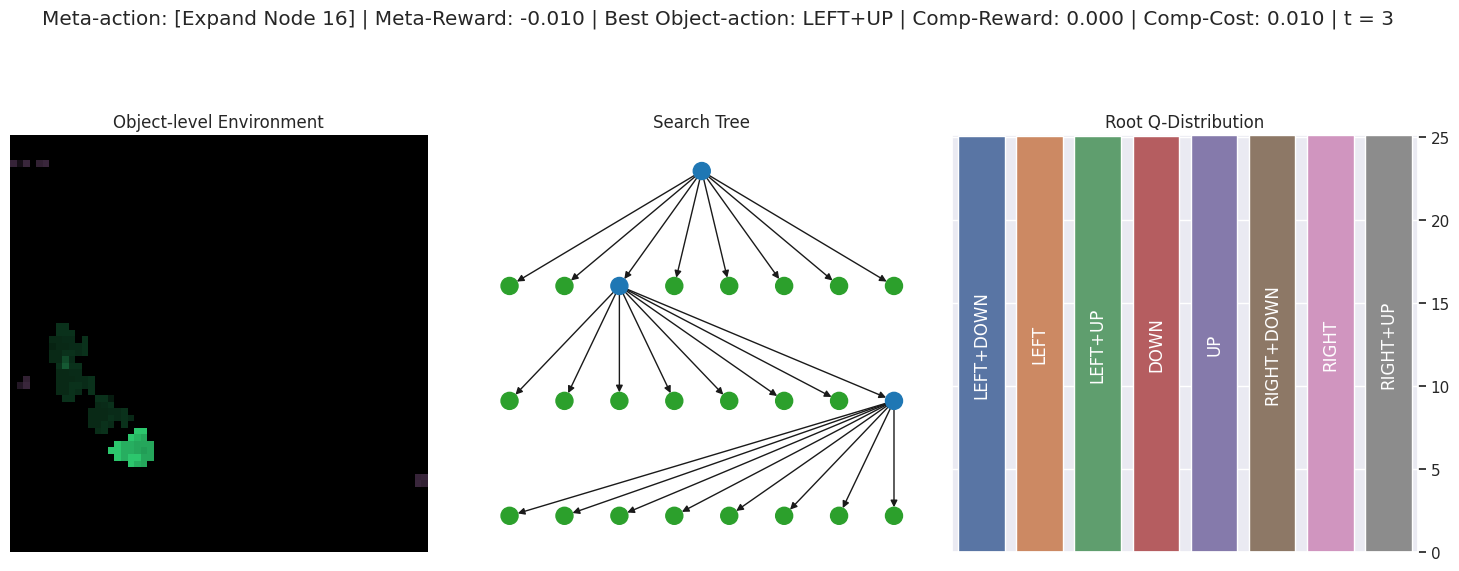

Estimating value of new policy:
 {ProcgenState(-5924664988174711309)}
|---[LEFT+DOWN, 0.000, 25.030]--> (ProcgenState(-4242163094017393146))
|---[LEFT, 0.000, 25.066]--> (ProcgenState(1356534834892271506))
|---[LEFT+UP, 0.000, 25.016]--> {ProcgenState(-5412069882440124751)}
	|---[LEFT+DOWN, 0.000, 25.141]--> {ProcgenState(-5839237696344012512)}
		|---[LEFT+DOWN, 0.000, 24.893]--> (ProcgenState(254361470913049179))
		|---[LEFT, 0.000, 25.376]--> (ProcgenState(-304233492797018256))
		|---[LEFT+UP, 0.000, 25.763]--> (ProcgenState(827406517007360574))
		|---[DOWN, 0.000, 25.281]--> (ProcgenState(8537204388797152630))
		|---[UP, 0.000, 25.499]--> (ProcgenState(-3544298136830264633))
		|---[RIGHT+DOWN, 0.000, 25.177]--> (ProcgenState(7214590018804461700))
		|---[RIGHT, 0.000, 25.612]--> (ProcgenState(8159560240935565082))
		|---[RIGHT+UP, 0.000, 25.554]--> (ProcgenState(-2315049594613841671))
	|---[LEFT, 1.000, 25.132]--> (ProcgenState(7349699056094574221))
	|---[LEFT+UP, 1.000, 25.228]--> (

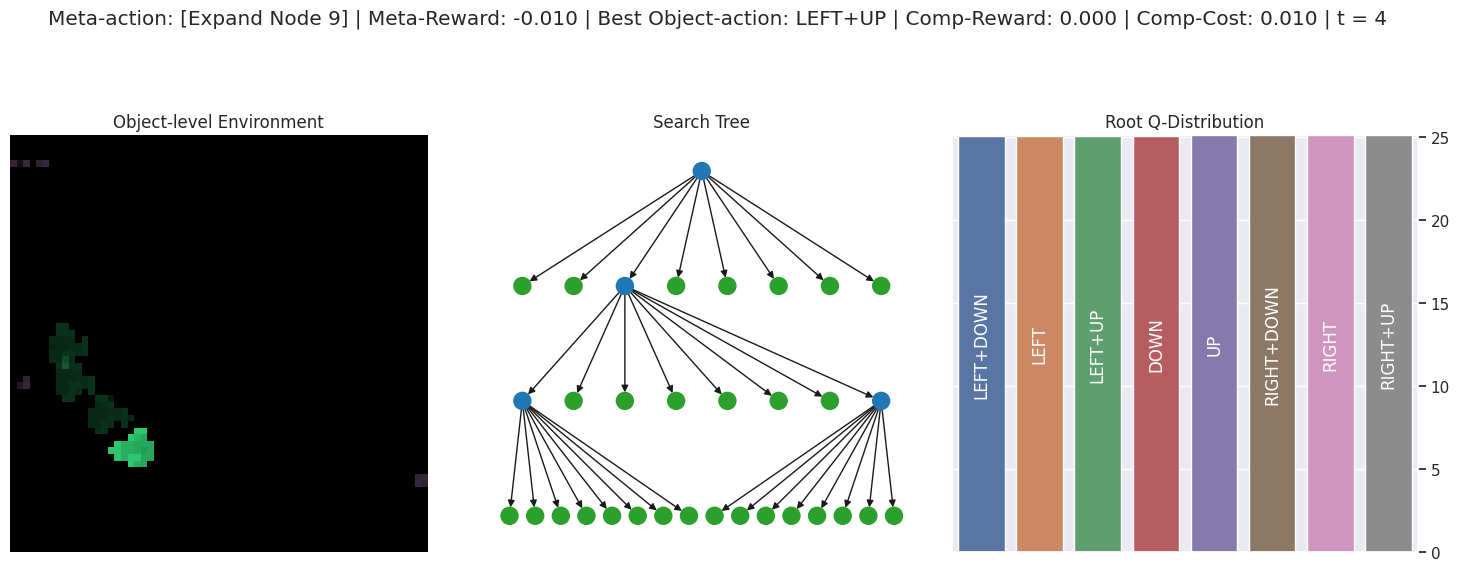

Estimating value of new policy:
 (ProcgenState(-5412069882440124751))
P(LEFT+DOWN | ProcgenState(-5412069882440124751)) = 0.0, P(LEFT | ProcgenState(-5412069882440124751)) = 0.0, P(LEFT+UP | ProcgenState(-5412069882440124751)) = 0.0, P(DOWN | ProcgenState(-5412069882440124751)) = 0.0, P(UP | ProcgenState(-5412069882440124751)) = 1.0, P(RIGHT+DOWN | ProcgenState(-5412069882440124751)) = 0.0, P(RIGHT | ProcgenState(-5412069882440124751)) = 0.0, P(RIGHT+UP | ProcgenState(-5412069882440124751)) = 0.0
Leaf evaluation: Q-hat(ProcgenState(-5412069882440124751), UP) = 25.26884
Value(ProcgenState(-5412069882440124751)) = 25.26884

Estimating value of prior policy:
 (ProcgenState(-5412069882440124751))
P(LEFT+DOWN | ProcgenState(-5412069882440124751)) = 0.0, P(LEFT | ProcgenState(-5412069882440124751)) = 0.0, P(LEFT+UP | ProcgenState(-5412069882440124751)) = 1.0, P(DOWN | ProcgenState(-5412069882440124751)) = 0.0, P(UP | ProcgenState(-5412069882440124751)) = 0.0, P(RIGHT+DOWN | ProcgenState(-541

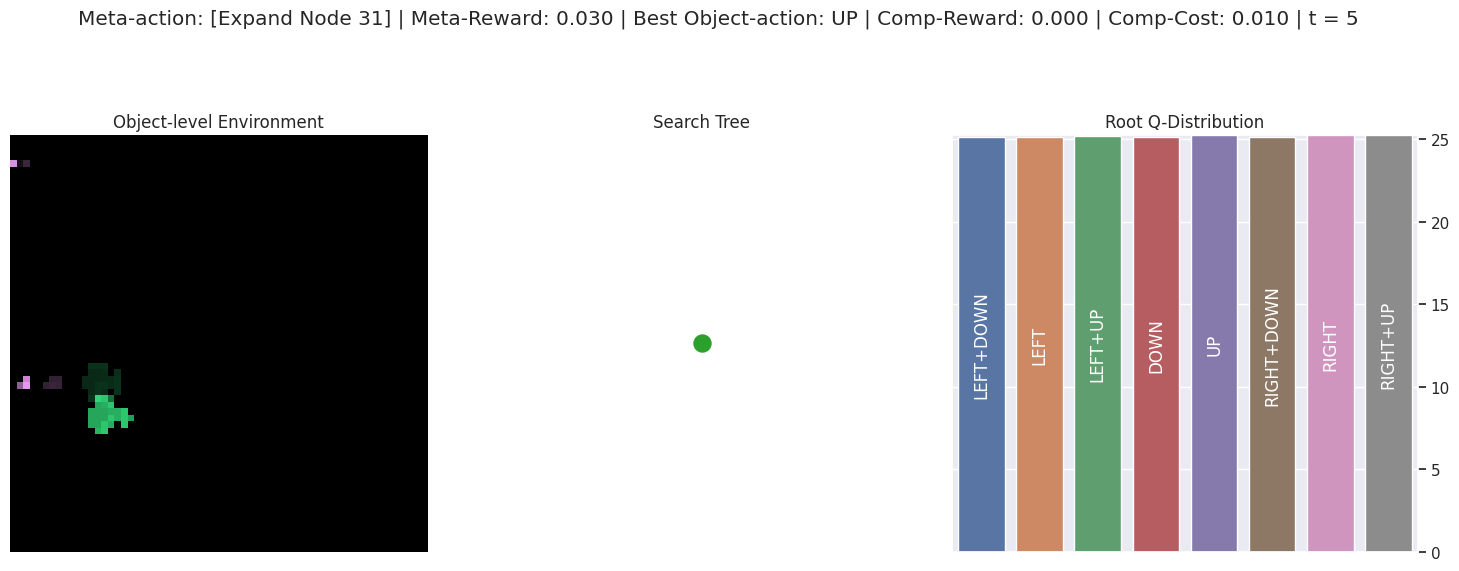

time_step.is_last()[0] = True 	 time_step.is_first()[0] = False


In [5]:
from IPython.display import clear_output

try:
    time_step = runner.collect_env.reset()
    running = True
    while not time_step.is_last()[0]:
        runner.collect_env.envs[0].render(plt_show=True)
        # clear_output(wait=True)
        time_step = runner.collect_env.current_time_step()
        policy_step = runner.collect_policy.action(time_step)
        next_time_step = runner.collect_env.step(policy_step.action)

        print(f'{time_step.is_last()[0] = } \t {time_step.is_first()[0] = }')
        # cmd = input()
        # while cmd:
        #     exec(cmd)
        #     cmd = input()

except KeyboardInterrupt:
    pass

In [7]:
batched_meta_envs.current_time_step().is_last()[0]

NameError: name 'batched_meta_env' is not defined

In [90]:
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from mlrl.experiments.procgen_meta import create_procgen_meta_env

batched_py_env = BatchedPyEnvironment([
    GymWrapper(create_procgen_meta_env(
        config,
        min_computation_steps=5,
        **args
    ))
    for _ in range(8)
], multithreading=True)

In [91]:
from mlrl.meta.meta_policies.search_ppo_agent import create_search_ppo_agent

meta_agent = create_search_ppo_agent(batched_py_env, args)

In [102]:
from tf_agents.train.utils import spec_utils

In [105]:
spec_utils.get_tensor_specs(batched_py_env) == spec_utils.get_tensor_specs(runner.collect_env)

True

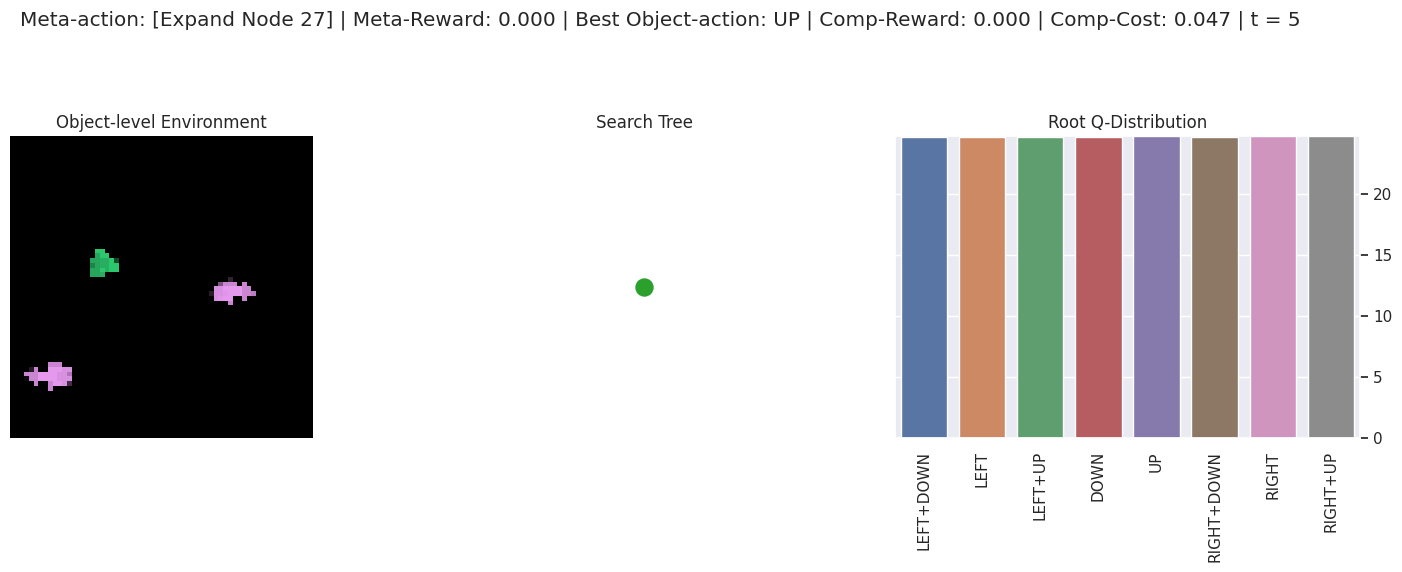

In [94]:
from IPython.display import clear_output

try:
    time_step = batched_py_env.reset()
    while True:
        batched_py_env.envs[0].gym.render(plt_show=True)
        clear_output(wait=True)
        time_step = batched_py_env.current_time_step()
        policy_step = meta_agent.policy.action(time_step)
        batched_py_env.step(policy_step.action)

except KeyboardInterrupt:
    pass

In [57]:
runner.collect_env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': OrderedDict([('action_mask',
                              BoundedArraySpec(shape=(33,), dtype=dtype('int32'), name='observation/action_mask', minimum=0, maximum=1)),
                             ('search_tree_tokens',
                              BoundedArraySpec(shape=(33, 544), dtype=dtype('float32'), name='observation/search_tree_tokens', minimum=0.0, maximum=1.0))]),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

In [64]:
runner.collect_env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': OrderedDict([('action_mask',
                              BoundedArraySpec(shape=(33,), dtype=dtype('int32'), name='observation/action_mask', minimum=0, maximum=1)),
                             ('search_tree_tokens',
                              BoundedArraySpec(shape=(33, 544), dtype=dtype('float32'), name='observation/search_tree_tokens', minimum=0.0, maximum=1.0))]),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

In [75]:
time_step = runner.collect_env.reset()
time_step.observation['search_tree_tokens'].shape

(16, 33, 544)

In [81]:
time_step = runner.collect_env.current_time_step()

In [83]:
time_step.observation['search_tree_tokens'].shape

(16, 33, 544)

In [68]:
runner.collect_env.envs[0].tree.root_node.state.get_action_vector_dim()

8

In [61]:
len(runner.collect_env.envs[0].get_token_labels())

544

In [33]:
import numpy as np

In [34]:
time_step.observation['search_tree_tokens'] = np.array(time_step.observation['search_tree_tokens'], dtype=np.float32)

In [55]:
print(', '.join(runner.collect_env.envs[0].get_token_labels()))

obs_mask, can_expand, reward, exp_root_return, path_return, exp_value, id_0, id_1, id_2, id_3, id_4, id_5, id_6, id_7, parent_id_0, parent_id_1, parent_id_2, parent_id_3, parent_id_4, parent_id_5, parent_id_6, parent_id_7, action_taken_0, action_taken_1, action_taken_2, action_taken_3, action_taken_4, action_taken_5, action_taken_6, action_taken_7, state_0, state_1, state_2, state_3, state_4, state_5, state_6, state_7, state_8, state_9, state_10, state_11, state_12, state_13, state_14, state_15, state_16, state_17, state_18, state_19, state_20, state_21, state_22, state_23, state_24, state_25, state_26, state_27, state_28, state_29, state_30, state_31, state_32, state_33, state_34, state_35, state_36, state_37, state_38, state_39, state_40, state_41, state_42, state_43, state_44, state_45, state_46, state_47, state_48, state_49, state_50, state_51, state_52, state_53, state_54, state_55, state_56, state_57, state_58, state_59, state_60, state_61, state_62, state_63, state_64, state_65,

In [24]:
meta_env = batched_meta_envs.envs[0]
meta_env.optimal_q_estimator.estimate_and_cache_optimal_q_values(meta_env.tree, verbose=True)

Estimating optimal Q-values for state ProcgenState(-2522429777864782876) from nodes:
{ProcgenState(-2522429777864782876)}
|---[LEFT+DOWN, 0.000, 23.473]--> (ProcgenState(-4359862315731399940))
|---[LEFT, 0.000, 23.373]--> (ProcgenState(-8736945973165008015))
|---[LEFT+UP, 0.000, 23.258]--> (ProcgenState(3570183212870787514))
|---[DOWN, 0.000, 23.635]--> (ProcgenState(-6148961146594993678))
|---[, 0.000, 23.654]--> {ProcgenState(824124212623684485)}
	|---[LEFT+DOWN, 0.000, 23.752]--> (ProcgenState(8725464451559862681))
	|---[LEFT, 0.000, 23.811]--> (ProcgenState(-1790866207731595961))
	|---[LEFT+UP, 0.000, 23.735]--> (ProcgenState(-5410031996700591145))
	|---[DOWN, 0.000, 23.845]--> (ProcgenState(-5590838365271865445))
	|---[, 0.000, 23.853]--> (ProcgenState(-8712967105145772294))
	|---[UP, 0.000, 23.736]--> (ProcgenState(-2778092589704709232))
	|---[RIGHT+DOWN, 0.000, 23.810]--> (ProcgenState(7385084315187554417))
	|---[RIGHT, 0.000, 23.805]--> (ProcgenState(-1682946420649093522))
	|--